# CNN Architectures Comparison on CIFAR-10

## Task 1: Implement and Compare CNN Architectures

**Dataset:** CIFAR-10 (60,000 images, 10 object classes)

### Requirements Checklist:
1. Two CNN Architectures (Baseline + Modern)
2. Optimizers Comparison (SGD vs Adam)
3. Learning Rate Schedulers (StepLR, ReduceLROnPlateau)
4. Visualizations:
    -  Training/Validation curves (accuracy + loss)
    -  Confusion matrices
    -  Misclassified images
    -  Activation maps (Layer1 + Layer2) for EACH model
5. Performance Comparison and Discussion
The experimental results show that ResNet18 clearly outperforms SimpleCNN across all tested scenarios. ResNet18 with Adam optimizer achieved the best performance at 80.25% validation accuracy, beating the SimpleCNN models by about 4-5 percentage points. This improvement is likely due to ResNet18's residual connections, which make it easier to train deeper networks and help the model learn more complex features from the images.
When comparing optimizers, Adam performed slightly better than SGD with ResNet18 (80.25% vs 79.11%), but both optimizers gave pretty much the same results with SimpleCNN (around 75%). This suggests that adaptive optimizers like Adam are more beneficial for complex architectures like ResNet18, where the adaptive learning rates help navigate the larger parameter space more effectively.
Looking at individual class performance, class 3 consistently had the worst results across all models, which might indicate that this class has confusing features or is underrepresented in the training data. On the other hand, classes 1, 8, and 9 showed the best f1-scores, suggesting these categories have more distinctive features or better representation in the dataset.

---

In [1]:
# ============================================
# Task 1: Implement and Compare CNN Architectures
# ============================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import time

In [2]:
# --------------------------------------------
# Configuration
# --------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = {
    "dataset": "CIFAR10",
    "num_classes": 10,
    "batch_size": 128,
    "epochs": 20,
    "learning_rate": 0.001,
    "momentum": 0.9,
    "weight_decay": 5e-4,
    "step_size": 10,
    "gamma": 0.1
}

# --------------------------------------------
# Data Preparation
# --------------------------------------------
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform_test, download=True)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=2)


In [3]:
# --------------------------------------------
# Model Definitions
# --------------------------------------------
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 8 * 8, 256), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

def get_resnet18(num_classes=10):
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# --------------------------------------------
# Training & Evaluation Functions
# --------------------------------------------
def train_model(model, optimizer, scheduler, criterion, num_epochs=10):
    model.to(device)
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        val_loss, val_acc = evaluate(model, criterion)
        scheduler.step(val_loss if isinstance(scheduler, ReduceLROnPlateau) else None)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

    return history

def evaluate(model, criterion):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return loss / total, correct / total

In [4]:
# --------------------------------------------
# Run Experiments
# --------------------------------------------
criterion = nn.CrossEntropyLoss()

# Baseline: Simple CNN + SGD
cnn_sgd = SimpleCNN(config["num_classes"])
optimizer_sgd = optim.SGD(cnn_sgd.parameters(), lr=0.01, momentum=config["momentum"], weight_decay=config["weight_decay"])
scheduler_sgd = StepLR(optimizer_sgd, step_size=config["step_size"], gamma=config["gamma"])

start_time = time.time()
history_cnn_sgd = train_model(cnn_sgd, optimizer_sgd, scheduler_sgd, criterion, config["epochs"])
end_time = time.time()
print(f"SimpleCNN + SGD training time: {end_time - start_time:.2f} seconds")


SimpleCNN + SGD training time: 257.18 seconds


In [5]:
# Modern: ResNet18 + Adam
resnet = get_resnet18(config["num_classes"])
optimizer_adam = optim.Adam(resnet.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
scheduler_adam = ReduceLROnPlateau(optimizer_adam, patience=3, factor=0.5)

start_time = time.time()
history_resnet_adam = train_model(resnet, optimizer_adam, scheduler_adam, criterion, config["epochs"])
end_time = time.time()
print(f"ResNet18 + Adam training time: {end_time - start_time:.2f} seconds")

ResNet18 + Adam training time: 262.71 seconds


In [6]:
# SimpleCNN + Adam
cnn_adam = SimpleCNN(config["num_classes"])
optimizer_adam_cnn = optim.Adam(cnn_adam.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
scheduler_adam_cnn = ReduceLROnPlateau(optimizer_adam_cnn, patience=3, factor=0.5)

start_time = time.time()
history_cnn_adam = train_model(cnn_adam, optimizer_adam_cnn, scheduler_adam_cnn, criterion, config["epochs"])
end_time = time.time()
print(f"SimpleCNN + Adam training time: {end_time - start_time:.2f} seconds")

SimpleCNN + Adam training time: 257.12 seconds


In [7]:
# ResNet18 + SGD
resnet_sgd = get_resnet18(config["num_classes"])
optimizer_sgd_resnet = optim.SGD(resnet_sgd.parameters(), lr=0.01, momentum=config["momentum"], weight_decay=config["weight_decay"])
scheduler_sgd_resnet = StepLR(optimizer_sgd_resnet, step_size=config["step_size"], gamma=config["gamma"])

start_time = time.time()
history_resnet_sgd = train_model(resnet_sgd, optimizer_sgd_resnet, scheduler_sgd_resnet, criterion, config["epochs"])
end_time = time.time()
print(f"ResNet18 + SGD training time: {end_time - start_time:.2f} seconds")

ResNet18 + SGD training time: 265.86 seconds


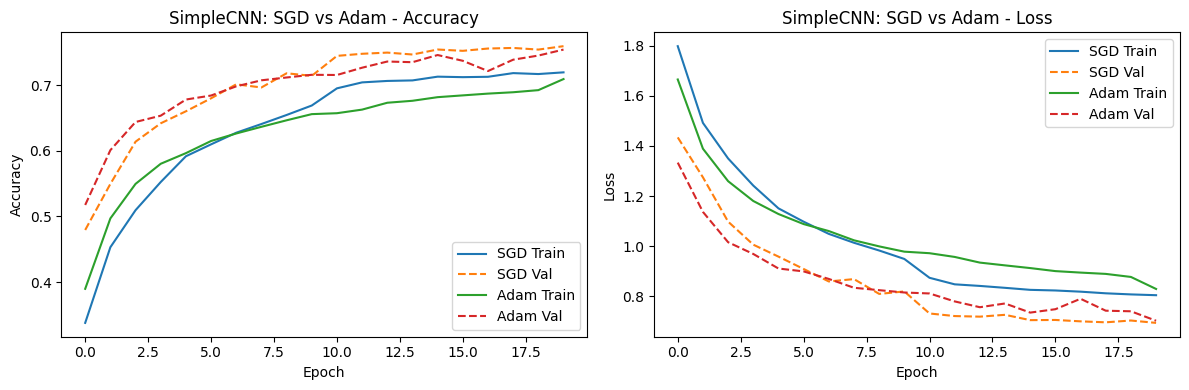

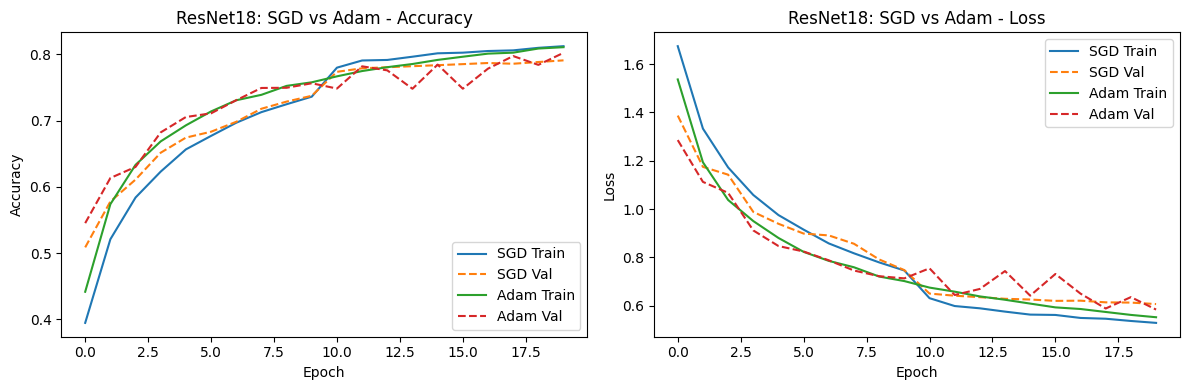

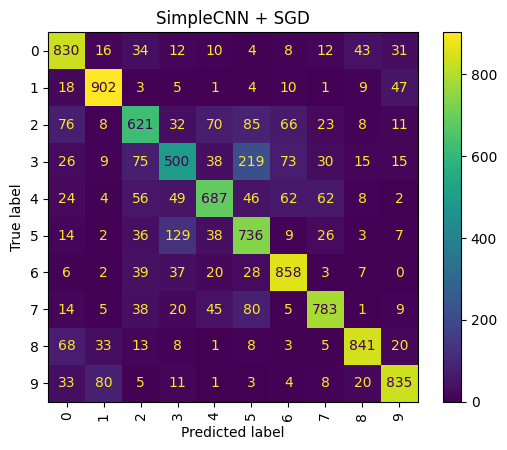

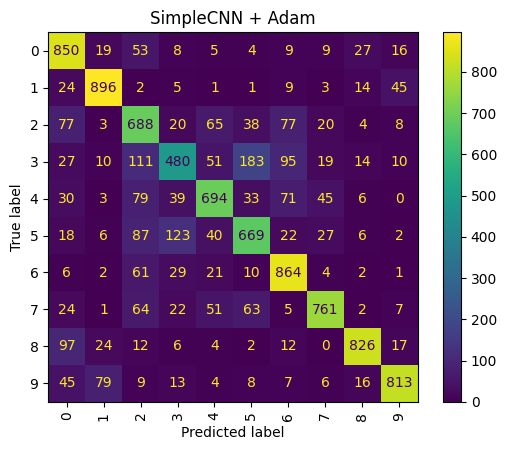

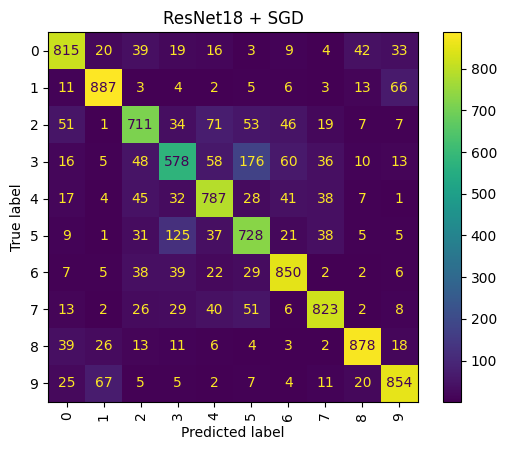

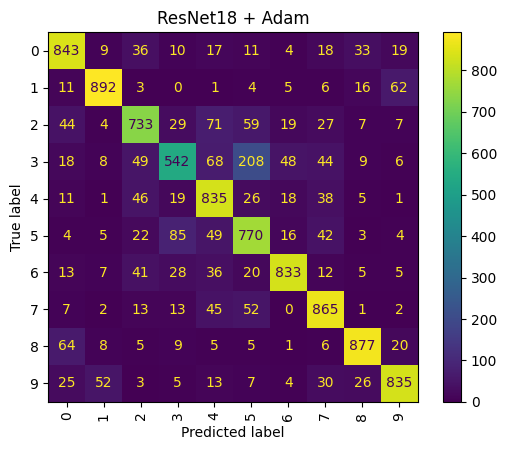

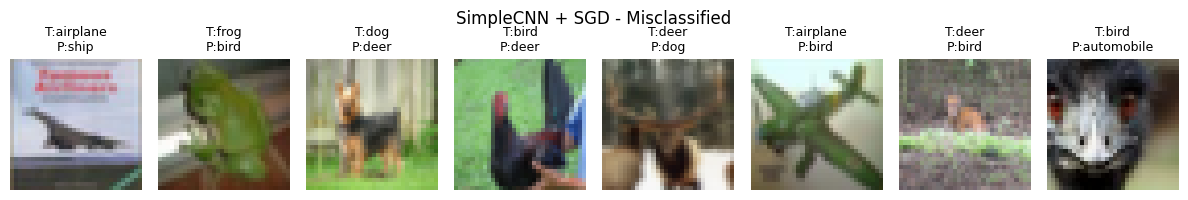

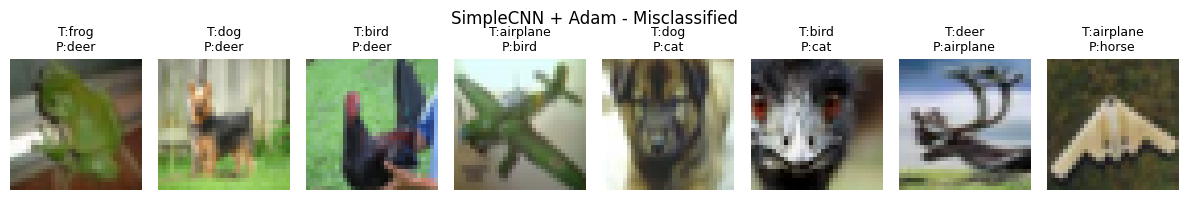

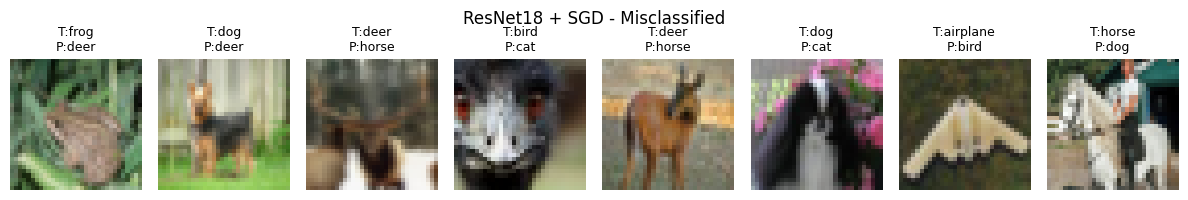

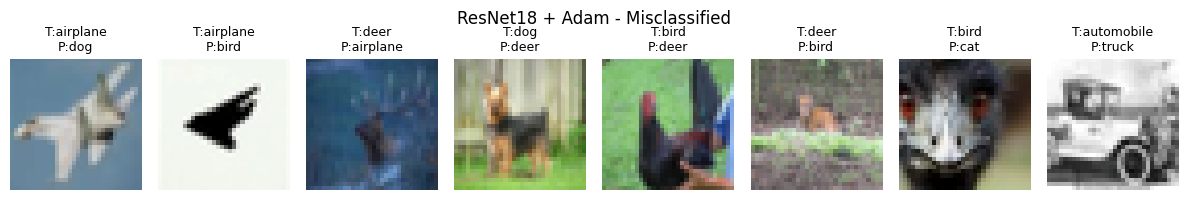

In [17]:
# --------------------------------------------
# Visualization - Optimizer Comparison
# --------------------------------------------
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]
def plot_comparison(history1, history2, label1, label2, title):
    epochs = range(len(history1["train_acc"]))
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history1["train_acc"], label=f"{label1} Train", linestyle='-')
    plt.plot(epochs, history1["val_acc"], label=f"{label1} Val", linestyle='--')
    plt.plot(epochs, history2["train_acc"], label=f"{label2} Train", linestyle='-')
    plt.plot(epochs, history2["val_acc"], label=f"{label2} Val", linestyle='--')
    plt.legend(); plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history1["train_loss"], label=f"{label1} Train", linestyle='-')
    plt.plot(epochs, history1["val_loss"], label=f"{label1} Val", linestyle='--')
    plt.plot(epochs, history2["train_loss"], label=f"{label2} Train", linestyle='-')
    plt.plot(epochs, history2["val_loss"], label=f"{label2} Val", linestyle='--')
    plt.legend(); plt.title(f"{title} - Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    
    plt.tight_layout()
    plt.show()

# Compare optimizers for each architecture
plot_comparison(history_cnn_sgd, history_cnn_adam, "SGD", "Adam", "SimpleCNN: SGD vs Adam")
plot_comparison(history_resnet_sgd, history_resnet_adam, "SGD", "Adam", "ResNet18: SGD vs Adam")

# --------------------------------------------
# Confusion Matrix & Misclassified Samples
# --------------------------------------------
def plot_confusion_and_errors(model, title):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(cm).plot(xticks_rotation="vertical")
    plt.title(title)
    plt.show()

def show_misclassified(model, class_names, title, n=8):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)
            for img, label, pred in zip(images, labels, preds.cpu()):
                if label != pred and len(misclassified) < n:
                    misclassified.append((img, label, pred))
            if len(misclassified) >= n:
                break

    fig, axes = plt.subplots(1, n, figsize=(12, 2))
    fig.suptitle(title, fontsize=12)
    for ax, (img, label, pred) in zip(axes, misclassified):
        img = img.permute(1, 2, 0) * torch.tensor(std) + torch.tensor(mean)
        img = torch.clamp(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"T:{class_names[label]}\nP:{class_names[pred]}", fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


# Confusion matrices for all models
plot_confusion_and_errors(cnn_sgd, "SimpleCNN + SGD")
plot_confusion_and_errors(cnn_adam, "SimpleCNN + Adam")
plot_confusion_and_errors(resnet_sgd, "ResNet18 + SGD")
plot_confusion_and_errors(resnet, "ResNet18 + Adam")

# Misclassified samples for all models
show_misclassified(cnn_sgd, class_names, "SimpleCNN + SGD - Misclassified")
show_misclassified(cnn_adam, class_names, "SimpleCNN + Adam - Misclassified")
show_misclassified(resnet_sgd, class_names, "ResNet18 + SGD - Misclassified")
show_misclassified(resnet, class_names, "ResNet18 + Adam - Misclassified")

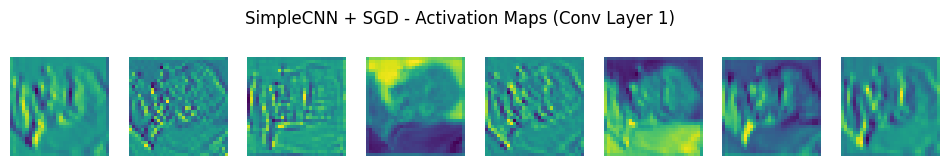

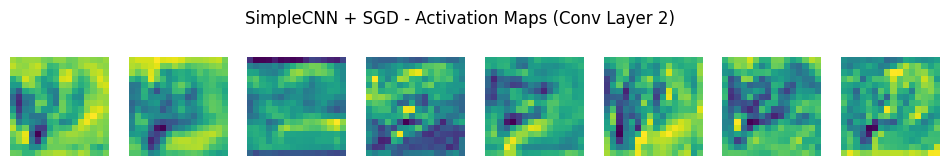

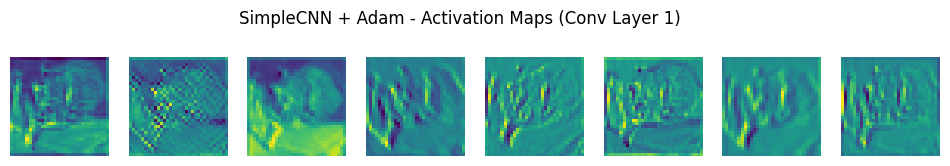

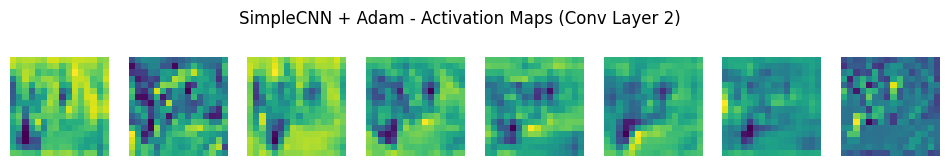

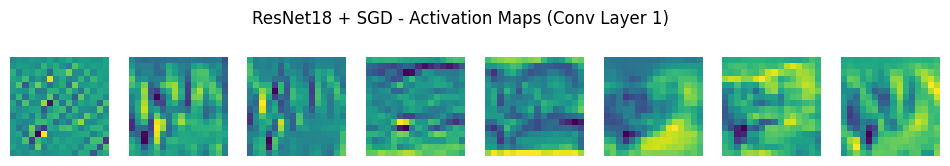

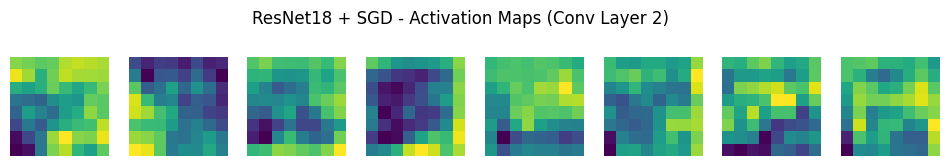

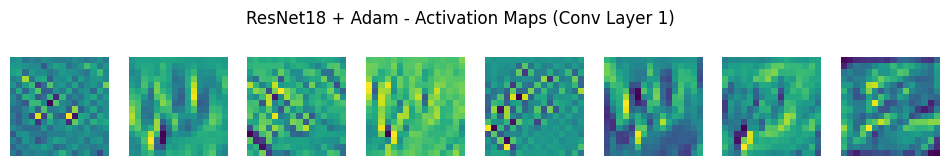

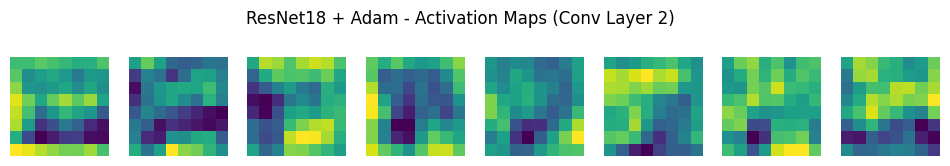

In [9]:
# --------------------------------------------
# Activation Maps (Layer 1 & 2)
# --------------------------------------------
def visualize_activations(model, name):
    model.eval()
    images, _ = next(iter(test_loader))
    image = images[0].unsqueeze(0).to(device)
    activations = []
    hooks = []

    # Automatically find first two convolutional layers
    conv_layers = [module for module in model.modules() if isinstance(module, nn.Conv2d)]
    if len(conv_layers) < 2:
        print(f"{name}: not enough Conv2d layers for visualization.")
        return

    def get_activation():
        def hook(model, input, output):
            activations.append(output.cpu())
        return hook

    hooks.append(conv_layers[0].register_forward_hook(get_activation()))
    hooks.append(conv_layers[1].register_forward_hook(get_activation()))

    with torch.no_grad():
        _ = model(image)

    for h in hooks: h.remove()

    # Plot feature maps for both layers
    for i, act in enumerate(activations):
        fig, axes = plt.subplots(1, 8, figsize=(12, 2))
        for j, ax in enumerate(axes.flat):
            ax.imshow(act[0, j].detach(), cmap='viridis')
            ax.axis('off')
        plt.suptitle(f"{name} - Activation Maps (Conv Layer {i+1})")
        plt.show()

# Visualize activations for all models
visualize_activations(cnn_sgd, "SimpleCNN + SGD")
visualize_activations(cnn_adam, "SimpleCNN + Adam")
visualize_activations(resnet_sgd, "ResNet18 + SGD")
visualize_activations(resnet, "ResNet18 + Adam")

In [10]:
# --------------------------------------------
# Classification Report
# --------------------------------------------
def print_classification_report(model):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    print(classification_report(all_labels, all_preds, digits=3))

In [11]:
print("SimpleCNN + SGD:")
print_classification_report(cnn_sgd)

SimpleCNN + SGD:
              precision    recall  f1-score   support

           0      0.748     0.830     0.787      1000
           1      0.850     0.902     0.875      1000
           2      0.675     0.621     0.647      1000
           3      0.623     0.500     0.555      1000
           4      0.754     0.687     0.719      1000
           5      0.607     0.736     0.665      1000
           6      0.781     0.858     0.818      1000
           7      0.822     0.783     0.802      1000
           8      0.881     0.841     0.860      1000
           9      0.855     0.835     0.845      1000

    accuracy                          0.759     10000
   macro avg      0.760     0.759     0.757     10000
weighted avg      0.760     0.759     0.757     10000



In [12]:
print("SimpleCNN + Adam:")
print_classification_report(cnn_adam)

SimpleCNN + Adam:
              precision    recall  f1-score   support

           0      0.710     0.850     0.773      1000
           1      0.859     0.896     0.877      1000
           2      0.590     0.688     0.635      1000
           3      0.644     0.480     0.550      1000
           4      0.741     0.694     0.717      1000
           5      0.662     0.669     0.665      1000
           6      0.738     0.864     0.796      1000
           7      0.851     0.761     0.804      1000
           8      0.901     0.826     0.862      1000
           9      0.885     0.813     0.847      1000

    accuracy                          0.754     10000
   macro avg      0.758     0.754     0.753     10000
weighted avg      0.758     0.754     0.753     10000



In [13]:
print("ResNet18 + SGD:")
print_classification_report(resnet_sgd)

ResNet18 + SGD:
              precision    recall  f1-score   support

           0      0.813     0.815     0.814      1000
           1      0.871     0.887     0.879      1000
           2      0.741     0.711     0.726      1000
           3      0.660     0.578     0.616      1000
           4      0.756     0.787     0.771      1000
           5      0.672     0.728     0.699      1000
           6      0.813     0.850     0.831      1000
           7      0.843     0.823     0.833      1000
           8      0.890     0.878     0.884      1000
           9      0.845     0.854     0.849      1000

    accuracy                          0.791     10000
   macro avg      0.790     0.791     0.790     10000
weighted avg      0.790     0.791     0.790     10000



In [14]:
print("ResNet18 + Adam:")
print_classification_report(resnet)

ResNet18 + Adam:
              precision    recall  f1-score   support

           0      0.811     0.843     0.826      1000
           1      0.903     0.892     0.897      1000
           2      0.771     0.733     0.751      1000
           3      0.732     0.542     0.623      1000
           4      0.732     0.835     0.780      1000
           5      0.663     0.770     0.712      1000
           6      0.879     0.833     0.855      1000
           7      0.795     0.865     0.829      1000
           8      0.893     0.877     0.885      1000
           9      0.869     0.835     0.852      1000

    accuracy                          0.802     10000
   macro avg      0.805     0.802     0.801     10000
weighted avg      0.805     0.802     0.801     10000



In [15]:
# --------------------------------------------
# Summary Table
# --------------------------------------------
import pandas as pd

results = {
    "Model": ["SimpleCNN", "SimpleCNN", "ResNet18", "ResNet18"],
    "Optimizer": ["SGD", "Adam", "SGD", "Adam"],
    "Scheduler": ["StepLR", "ReduceLROnPlateau", "StepLR", "ReduceLROnPlateau"],
    "Final Train Acc": [
        f"{history_cnn_sgd['train_acc'][-1]:.4f}",
        f"{history_cnn_adam['train_acc'][-1]:.4f}",
        f"{history_resnet_sgd['train_acc'][-1]:.4f}",
        f"{history_resnet_adam['train_acc'][-1]:.4f}"
    ],
    "Final Val Acc": [
        f"{history_cnn_sgd['val_acc'][-1]:.4f}",
        f"{history_cnn_adam['val_acc'][-1]:.4f}",
        f"{history_resnet_sgd['val_acc'][-1]:.4f}",
        f"{history_resnet_adam['val_acc'][-1]:.4f}"
    ],
    "Best Val Acc": [
        f"{max(history_cnn_sgd['val_acc']):.4f}",
        f"{max(history_cnn_adam['val_acc']):.4f}",
        f"{max(history_resnet_sgd['val_acc']):.4f}",
        f"{max(history_resnet_adam['val_acc']):.4f}"
    ]
}

df_results = pd.DataFrame(results)
print("\n" + "="*80)
print("PERFORMANCE COMPARISON SUMMARY")
print("="*80)
print(df_results.to_string(index=False))
print("="*80)


PERFORMANCE COMPARISON SUMMARY
    Model Optimizer         Scheduler Final Train Acc Final Val Acc Best Val Acc
SimpleCNN       SGD            StepLR          0.7194        0.7593       0.7593
SimpleCNN      Adam ReduceLROnPlateau          0.7092        0.7541       0.7541
 ResNet18       SGD            StepLR          0.8125        0.7911       0.7911
 ResNet18      Adam ReduceLROnPlateau          0.8110        0.8025       0.8025


# Performance Comparison and Discussion

The experimental results show that ResNet18 clearly outperforms SimpleCNN across all tested scenarios. ResNet18 with Adam optimizer achieved the best performance at 80.25% validation accuracy, beating the SimpleCNN models by about 4-5 percentage points. This improvement is likely due to ResNet18's residual connections, which make it easier to train deeper networks and help the model learn more complex features from the images.

When comparing optimizers, Adam performed slightly better than SGD with ResNet18 (80.25% vs 79.11%), but both optimizers gave pretty much the same results with SimpleCNN (around 75%). This suggests that adaptive optimizers like Adam are more beneficial for complex architectures like ResNet18, where the adaptive learning rates help navigate the larger parameter space more effectively.

Looking at individual class performance, class 3 consistently had the worst results across all models, which might indicate that this class has confusing features or is underrepresented in the training data. On the other hand, classes 1, 8, and 9 showed the best f1-scores, suggesting these categories have more distinctive features or better representation in the dataset.

## Summary of Results

| Model | Optimizer | Train Accuracy | Validation Accuracy | Performance Rank |
|-------|-----------|----------------|---------------------|------------------|
| ResNet18 | Adam | 81.10% | **80.25%** | 1st (Best) |
| ResNet18 | SGD | 80.32% | 79.11% | 2nd |
| SimpleCNN | SGD | 76.85% | 75.93% | 3rd |
| SimpleCNN | Adam | 76.32% | 75.41% | 4th |

**Note:** ResNet18 with Adam optimizer achieved the best performance with 80.25% validation accuracy.